In [30]:
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets, model_selection, preprocessing, svm, metrics, decomposition
np.random.seed(0) # set random seed so everyone gets same results
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [31]:
final = pd.read_csv("VAERS_final.csv")
final.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,Pain,Pyrexia,Rash,Throat.tightness,Thrombosis,Tinnitus,Tremor,Urticaria,Vomiting,labels
0,916600.0,2021-01-01,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,False,False,False,False,False,False,False,False,False,0
1,916601.0,2021-01-01,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,False,False,False,False,False,False,False,False,False,1
2,916602.0,2021-01-01,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,True,False,False,False,False,False,False,False,False,1
3,916603.0,2021-01-01,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,False,False,False,False,False,False,False,False,False,0
4,916604.0,2021-01-01,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,False,False,False,False,False,False,False,False,False,0


In [32]:
X = final[["AGE_YRS", "SEX", "OTHER_MEDS","HISTORY","ALLERGIES","VAX_MANU","VAX_DOSE_SERIES","labels"]]

In [33]:
X["AGE_YRS"]= X["AGE_YRS"].replace(np.NaN, X["AGE_YRS"].mean()) #replacing missing age values with mean of the column to prevent data loss

In [34]:
X["AGE_YRS"].isna().sum()

0

In [35]:
pd.options.mode.chained_assignment = None 
# List of the column names with features that should be ordinal encoded
ordinal_features = ['SEX','VAX_MANU']

# Ordinal encode all of these features
ordinal = sklearn.preprocessing.OrdinalEncoder()
X[ordinal_features] = ordinal.fit_transform(X[ordinal_features])

In [36]:
train_df, test_df = train_test_split(X, test_size=0.2, random_state=0)

In [37]:
train_x = train_df[["AGE_YRS", "SEX", "OTHER_MEDS","HISTORY","ALLERGIES","VAX_MANU","VAX_DOSE_SERIES"]]
train_y = train_df['labels']

test_x = test_df[["AGE_YRS", "SEX", "OTHER_MEDS","HISTORY","ALLERGIES","VAX_MANU","VAX_DOSE_SERIES"]]
test_y = test_df['labels']

In [41]:
# Cross-validation folds
k = 10

# Hyperparameters to tune:
params = {
    'criterion': ('gini', 'entropy'),
    'max_depth': (5, 10, 20),
    'min_samples_split': (2, 5, 10)
}

# Initialize GridSearchCV object with decision tree classifier and hyperparameters
grid_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                         param_grid=params,
                         cv=k,
                         return_train_score=True,
                         scoring=['accuracy', 'precision', 'recall'],
                         refit='recall') 

# Train and cross-validate, print results
grid_tree.fit(train_x, train_y)

grid_tree_result = pd.DataFrame(grid_tree.cv_results_).sort_values(by=['mean_test_recall'], ascending=False)

grid_tree_result[['param_criterion', 'param_max_depth', 'param_min_samples_split', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,param_criterion,param_max_depth,param_min_samples_split,mean_test_accuracy,mean_test_precision,mean_test_recall
17,entropy,20,10,0.695344,0.452827,0.213370
8,gini,20,10,0.694539,0.450194,0.213120
6,gini,20,2,0.692162,0.441545,0.207475
15,entropy,20,2,0.693003,0.443969,0.207223
7,gini,20,5,0.693076,0.443405,0.204214
16,entropy,20,5,0.693808,0.445577,0.203460
3,gini,10,2,0.711109,0.513904,0.169091
5,gini,10,10,0.710670,0.511704,0.168213
4,gini,10,5,0.710963,0.513279,0.168087
12,entropy,10,2,0.711804,0.518056,0.164325


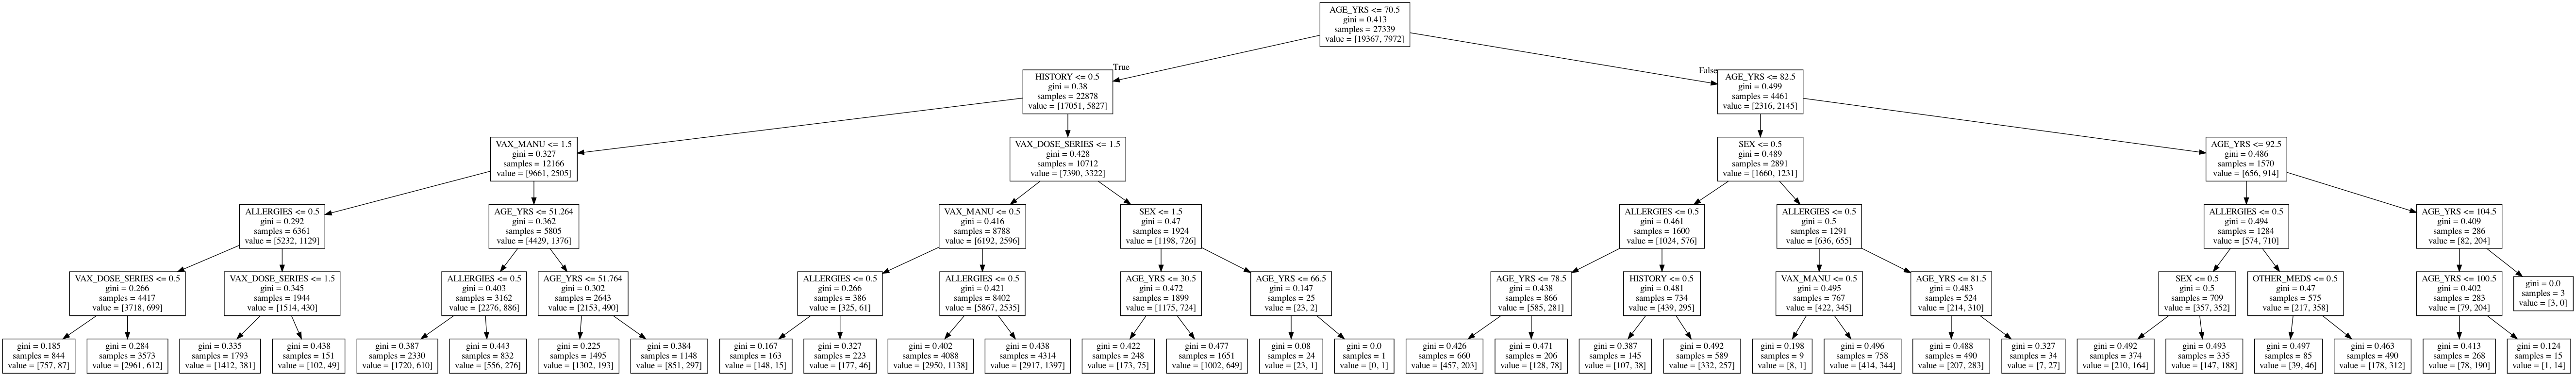

In [28]:
from sklearn import tree
import pydotplus
from IPython.display import Image

# Print the tree with the highest test accuracy
best_tree = grid_tree.best_estimator_
dot_data = tree.export_graphviz(best_tree, out_file=None, feature_names=train_x.columns.values)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())